# **Active Learning Agents for Soft Material Phase Mapping**

## **Tutorial Notebook**

*Tyler Martin, Peter Beaucage, Shijing Sun, Gilad Kusne*

Spring 2024 Materials Research Society Meeting

Tutorial MT00 - MLMR Competition

Monday April 22, 2024


# Setup

**This may take several minutes to complete, please run ASAP**

Please run this collapsed cell by clicking in the box to the left of *8 cells hidden*. This will `pip install` and `import` all necessary dependencies for this tutorial. There is not need to expand this cell block, but you can if you're interested in looking under the hood.


If you've never used Google Colab before, [this FAQ](https://research.google.com/colaboratory/faq.html) may be useful to skim. It's very similar (and based off of) Jupyter, but divergent in several ways.

**Warning!**

If you disconnect for too long, you'll have to rerun this cell. Any text you type into this notebooks should always be saved, but variables in memory and files can dissappear when you disconnect.

You're free to download this notebook and run it locally if you're inclined, but we will provide no support for this.


In [ ]:
!git clone https://github.com/martintb/active_learning_tutorial.git

In [ ]:
%cd /content/active_learning_tutorial

In [ ]:
!pip install -e .

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gpflow

import sklearn.cluster
from sklearn.metrics import pairwise
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern

import plotly.express as px
import plotly.graph_objects as go

import xarray as xr
xr.set_options(display_expand_data=False)

In [ ]:
from tutlib import *
from tutlib.instruments.tutorial import *

In [ ]:
%cd /content/active_learning_tutorial/

In [ ]:
np.random.seed(240424)

# Initialize Virtual Instrument



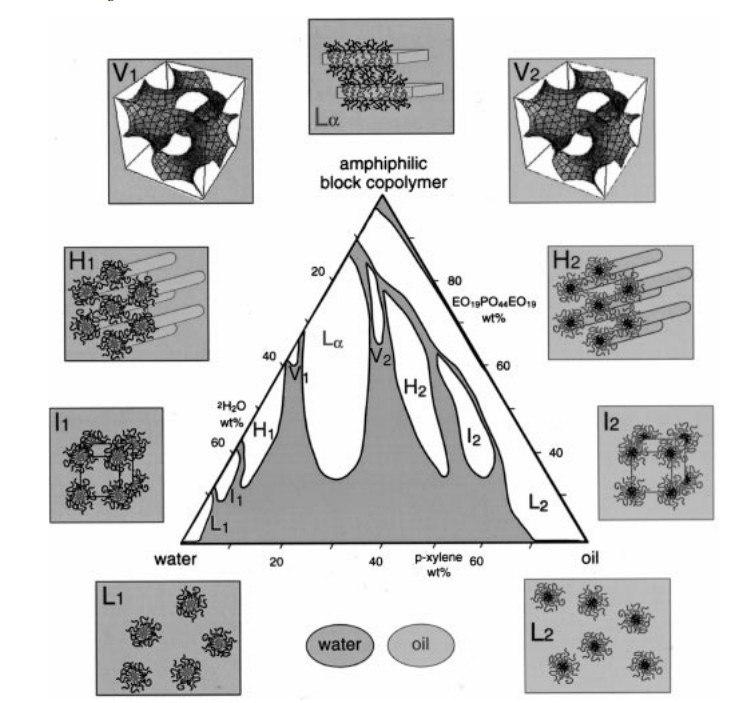

This competition will work with *virtual instruments* that generate realisitic small-angle neutron scattering (SANS) data that vary with sample composition. These data will include non-ideal effects like measurement noise and instrumental smearing. Each challenge with have an instrument with a different 'phase map' loaded into it and parameters for generating the scattering data.




All phase boundaries in this tutorial (and in the competition) come from  [Alexandridis et al, Langmuir 1998, 14, 2627-2638](https://pubs.acs.org/doi/pdf/10.1021/la971117c). While this paper focuses on X-ray diffraction measurements, our *virtual instruments* will generate analogous SANS data.

To start, let's initialize a virtual instrument.

In [ ]:
instrument = get_virtual_instrument()
instrument

We can view the 'ground truth' of this virtual instrument as so. The two colors in the ternary plot represent two phases. Hover over the diagram to view the composition at every point.

In [ ]:
instrument._plot_ground_truth_data()

Now, let's conduct a measurement at a mass fraction of

`(a, b, c) = (0.5, 0.0, 0.5)`

where a, b, and c, correspond to the mass fractions of pluronic, water, and oil. Note that, in this scheme a + b + c must sum to 1.0.

In [ ]:
dataset = instrument.measure(a=0.5,b=0.,c=0.5)
dataset

This returns an [xarray.Dataset](https://docs.xarray.dev/en/stable/) containing our virtual scattering data. We'll briefly discuss this data structure below but, first, let's plot the virtual scattering data from this 'measurement'.



In [ ]:
dataset.sas.plot.line(
    x='q',
    xscale='log',
    yscale='log',
    marker='.',
    ls='none',
)

Note how the above data has noise, stitching artifacts, and resolution effects. All of these will be important to consider in designing an active-learning agent.

We can also plot the composition the data was measured at in ternary coordinates using the helper function `plot_ternary`

**Important Note:** Plotly has issues displaying points on the ternary boundary. If you double click the ternary, it should show the point in the middle of the left side.

In [ ]:
plot_ternary(dataset,['c','a','b'],include_surface=False)


# A quick aside on xarray

Let's take a quick detour in to the primary data structure used in this challenge. See [here](https://tutorial.xarray.dev/intro.html) for a more detailed tutorial. If you've used [`pandas`](https://pandas.pydata.org/) before, this all should feel familiar.

The two primary datastructures in `xarray` are `DataArrays` and `Datasets`. `DataArrays` can be thought of as `Numpy` arrays that have named axes called "dimensions" and (optionally) defined coordinates on those axes.  *In xarray, the dimension 'x' and the positions along that dimension (x=0.5, 1.0, 1.5, etc) are separate concepts.*

To demonstrate this, let's look at the `Dataset` that was returned from the virtual instrument above


In [ ]:
dataset

From the top row of the output, we see that the Dataset has 250 values in the `q`.

Under the **Coordinates** header, we can view the coordinates defined for these dimensions. Think of coordinates as x-axis values in an x-y scatter plot.

Under the **Data variables** header, we can see that we have 4 data variables. Click the 'page' icon at the right side of each row to read a description of the variable. Note that each variable has *dimensions* listed in parenthesis. Think of data variables as the y-values in a x-y scattering plot.

We can view specific DataArrays within the Dataset using dictionary indexing like so

In [ ]:
dataset['sas']

Note that you can always get back the underlying Numpy arrays using the `values` attribute

In [ ]:
dataset['sas'].values

`Datasets` and `DataArrays` have many ways to index and slice data, here's a brief demonstration of a few of them. Note that all of these selections can be applied to the entire dataset or a specific `DataArray` within the dataset.

We can access the tenth value of the sas xarray using classic, integer-based array access notation

In [ ]:
dataset['sas'][10]


xarray allows us to be more explicit and specify the dimension we're searching over. In this case, we use the `.isel()` method (index select method)

In [ ]:
dataset['sas'].isel(q=10)

More powerfully, we can search for specific coordinate values (rather than integer indices) using `.sel()`.

In [ ]:
dataset['sas'].sel(q=0.003915, method='nearest')

We can also slice across a range of values using explicit coordinate values

In [ ]:
dataset['sas'].sel(q=slice(0.003,0.01))

Finally, we can interpolate our data to specific q coordinate

In [ ]:
dataset['sas'].interp(q=0.04)

There is a lot more going on with xarray, but hopefully this will allow us to get started.

# Make Starting Dataset


Now, let's build a starting dataset by 'measuring' at several compositions. Feel free to edit the list below to change which points the active learning code starts with.

In [ ]:
composition_list = [
    {'a':1/3,'b':1/3,'c':1/3},
    {'a':0.0,'b':0.5,'c':0.5},
    {'a':0.5,'b':0.0,'c':0.5},
    {'a':0.5,'b':0.5,'c':0.0},
]

input_dataset = instrument.measure_multiple(composition_list)
input_dataset

Note that the above code output a dataset with multiple entries in the **sample** dimension. Since the sample dimension does not have a coordinate defined for it, you can index it using integer indices.

Below we show how to plot the **sas** data variable.

In [ ]:
input_dataset.sas.plot.line(
    x='q',
    xscale='log',
    yscale='log',
    marker='.',
    ls='none',
)

We can also plot the compositions using the `plot_ternary` helper function. Remember to double-click the ternary to view the compositions along the edges.

In [ ]:
plot_ternary(input_dataset,components=['c','a','b'],include_surface=False)

As an aside, if you want to gather multiple `Dataset` variables into a single `DataArray` you can do so using `.to_array()`. Below, we gather the composition variables and covert them using this method

In [ ]:
input_dataset[['c','a','b']].to_array()

Notice that we now have a second "variable" dimension. You can choose the name of this dimension by passing a keyword argument to the `.to_array()` method.

Its common that we want the first dimension to be the **sample** dimension so we can add a transpose to complete the transform

In [ ]:
input_dataset[['c','a','b']].to_array().transpose('sample',...)

# Configure an Active Learning Agent

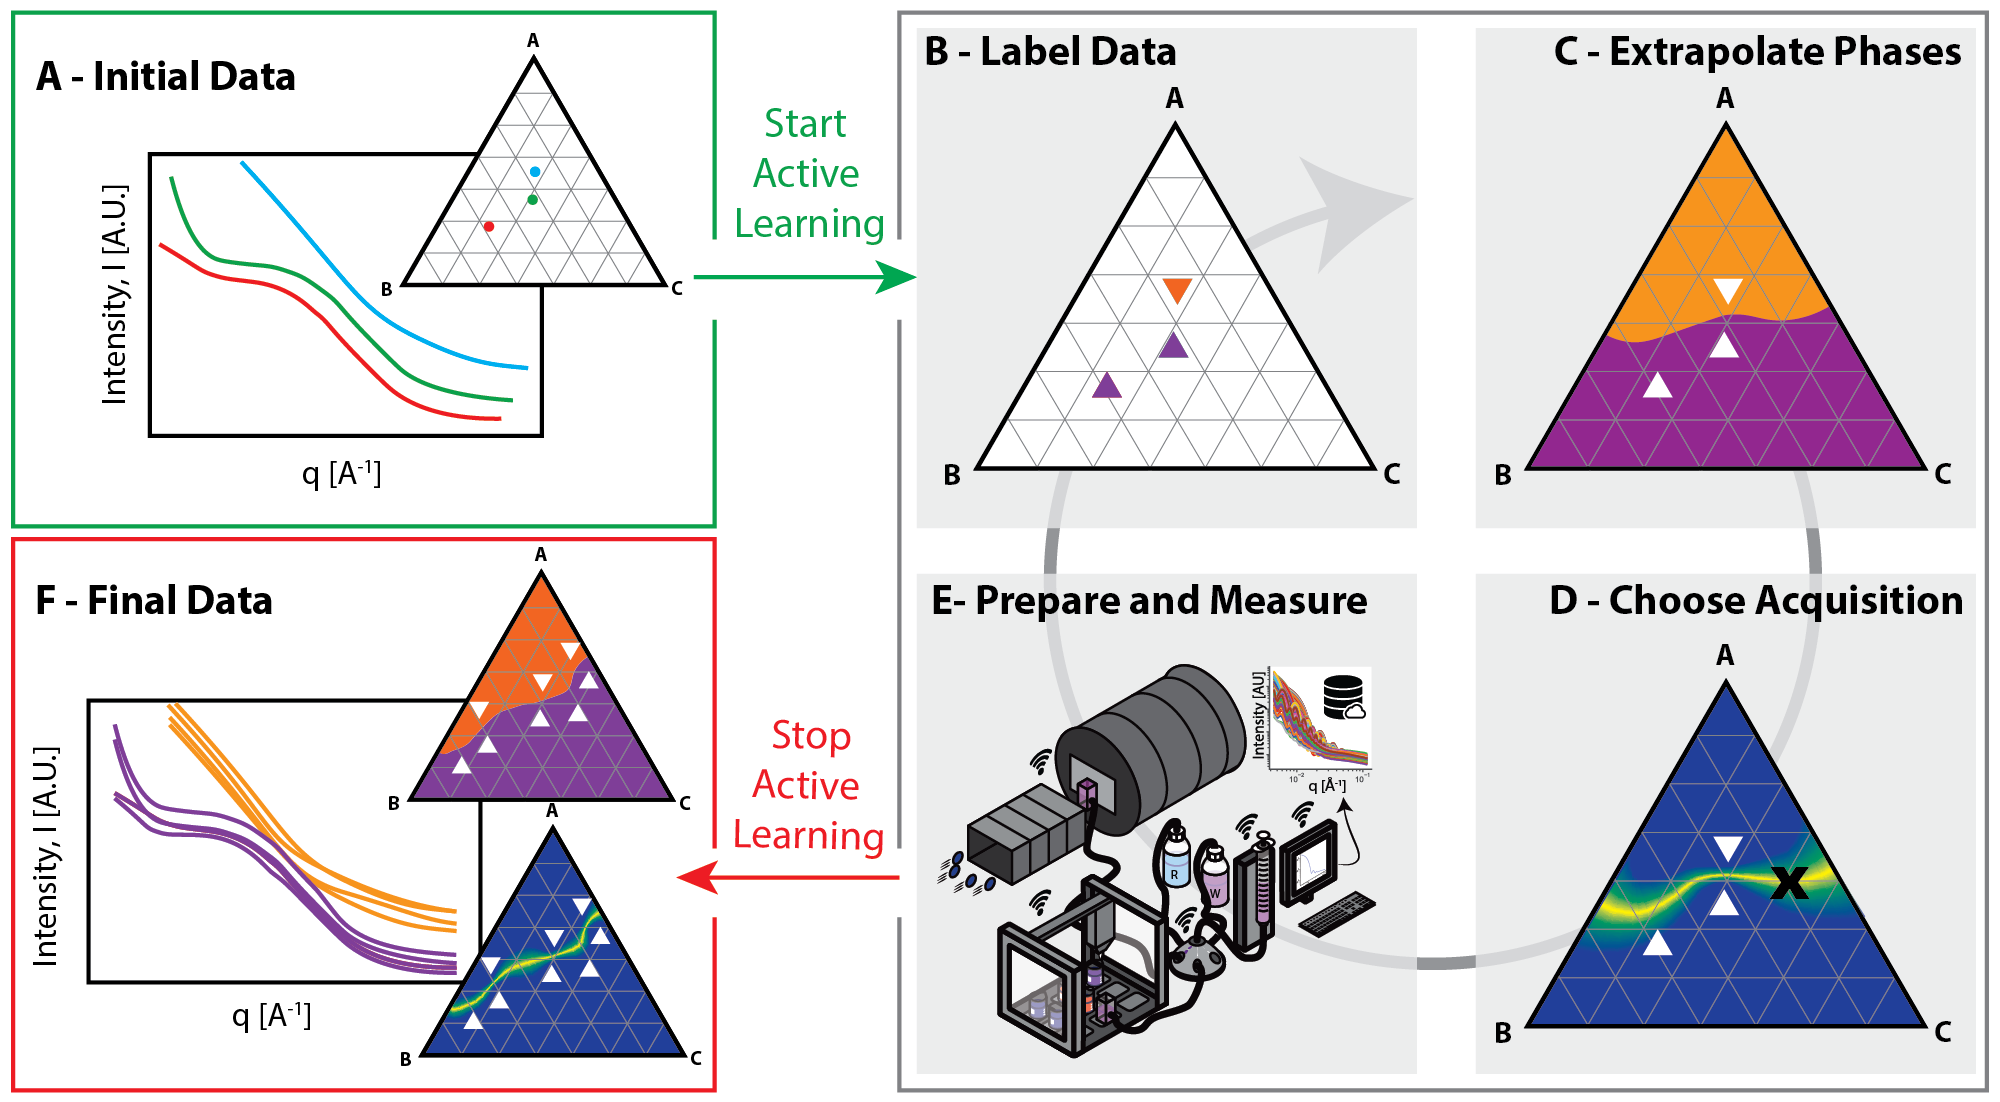


In the following section, you will define the three functions that make up the 'brain' of your active learning agent. Each of the functions will take in a `xarray.Dataset`, add variables and attributes, and the return the dataset so it can be passed to the next function.

The order of calling is *Label* -> *Extrapolate* -> *Choose Acquisition*. The same `xarray.Dataset` is passed to each method in order, so your goal is to modify the data put into this dataset.



## Label Method

The *label* function needs to create the *labels* variable which defines the phase identity of each measurement and the *n_phases* attribute which identifies the number of phases.

In [ ]:
def label( dataset: xr.Dataset, num_phases: int ) -> xr.Dataset:
    ''' A method which labels (classifies) the virtual scattering data

    Contract: Make the following changes to the 'dataset' variable
      - Set variables "labels" with dimension "sample"
      - Set attribute "n_phases"
    '''
    # create spectral clustering object
    clf = sklearn.cluster.SpectralClustering(
      n_clusters=num_phases,
      affinity='laplacian',
      gamma=1e-3
    )

    # apply clustering algorithm to sas data
    clf.fit(dataset['sas'])

    #store results in the dataset
    dataset['labels'] = ('sample', clf.labels_)
    dataset['labels'].attrs['description'] = 'ML-defined label for each measurement'
    dataset.attrs['n_phases'] = num_phases
    return dataset

Let's test this method by passing the input dataset through it and looking at the output.

In [ ]:
labeled_dataset = label(dataset=input_dataset,num_phases=2)
labeled_dataset

We can plot the results using `plot_ternary`. If you double click, you should see that only the symbol on the left side of the ternary is labeled with a different color and symbol.

In [ ]:
plot_ternary(labeled_dataset,['c','a','b'],include_surface=False)

## Extrapolate Method

The *extrapolate* method takes the measurement data at specific compositions, and extrapolates over all compositions. In this case, we will extrapolate over a predefined grid with variables ('c_grid','a_grid','b_grid'). We'll show you how to make this grid below.

In [ ]:
def extrapolate(dataset: xr.Dataset) -> xr.Dataset:
    ''' Extrapolate the labels from the previous step over a composition space

    Contract: Make the following changes to the 'dataset' variable
      - Set variable "labels_grid" with dimension "grid"
      - Set variable "labels_grid_prob" with dimensions ("grid","phase")
    '''
    # create and train a GP
    clf = GaussianProcessClassifier(
        kernel = Matern(
            length_scale_bounds=(0.05,0.25),
            nu=1.5
            ),
        )

    clf.fit(
        X=dataset[['c','a','b']].to_array().transpose('sample',...),
        y=dataset['labels']
    )

    # gather 'grid' of composition points to evaluate trained GP on
    Xp = dataset[['c_grid','a_grid','b_grid']].to_array().transpose('grid',...)

    # evaluate trained GP on grid
    labels_grid = clf.predict(Xp)

    # calculate entropy of prediction
    label_prob = clf.predict_proba(Xp)

    #store results in the dataset
    dataset['labels_grid_prob'] = (('grid','phase'), label_prob)
    dataset['labels_grid_prob'].attrs['description'] = 'Probability of each label at every composition of the grid'

    dataset['labels_grid'] = ('grid', labels_grid)
    dataset['labels_grid'].attrs['description'] = 'Most likely label at every composition of the grid'

    return dataset

Let's test this method on the results of our label method. We start by adding a grid to evalulate the extrapolated labels over and then call the method. Zoom into the ternary to see the individual grid points.

In [ ]:
grid = composition_grid_ternary(pts_per_row=100,basis=1.0)
labeled_dataset['a_grid'] = ('grid',grid[:,0])
labeled_dataset['b_grid'] = ('grid',grid[:,1])
labeled_dataset['c_grid'] = ('grid',grid[:,2])

plot_ternary(labeled_dataset,['c_grid','a_grid','b_grid'],include_surface=False, labels=None)

Now we can call the extrapolate method on our `labeled_dataset`.

In [ ]:
extrapolated_dataset = extrapolate(labeled_dataset)
extrapolated_dataset

The dataset is growing! Let's plot the extrapolated results

In [ ]:
plot_ternary(
    dataset = extrapolated_dataset,
    components = ['c','a','b'],
    labels='labels',
    include_surface=True,
    surface_data='labels_grid',
    surface_colorbar=False
    )

The color represents the most-likely phase according to the Gaussian process extrapolation.

## Acquisition Method

The *choose_next_acquisition* method identifies the next best measurement from the results of the *extrapolate* method. In this example, it simply chooses the composition that has the highest variance.

In [ ]:
def choose_next_acquisition(dataset: xr.Dataset) -> xr.Dataset:
    """Use information from previous methods to decide next optimal measurement

    Contract: Make the following changes to the 'dataset' variable
      - Set variables "acquisition" with dimension "grid"
      - add a dictionary named 'next_sample' to the attributes of dataset
      - next sample should be like {'a':0.1, 'b':0.2, 'c':0.7}
    """
    # calculate the acquisition surface from the label probability of the GP.
    # In this case, we'll calculate the entropy of the mean function.
    yp = dataset['labels_grid_prob']
    acquisition = (-np.log(yp)*yp).sum('phase')

    # get index max value of acquisition surface and cast to integer
    next_sample_index = int(acquisition.argmax())

    # get composition associated with selection
    next_sample_comp = dataset[['c_grid', 'a_grid', 'b_grid']].isel(grid = next_sample_index)

    next_sample_comp_dict = {k.replace('_grid',''):v for k,v in next_sample_comp.to_pandas().to_dict().items()}
    dataset.attrs['next_sample'] = next_sample_comp_dict

    dataset["acquisition"] = acquisition #don't need to specify dimension because it's already a DataArray
    dataset["acquisition"].attrs['description'] = "acquisition/decision surface"

    return dataset

Finally, we can pass the extrapolated dataset through this acquisition method to get our next measurement prediction.

In [ ]:
acquisition_dataset = choose_next_acquisition(extrapolated_dataset)
acquisition_dataset

Plotting the results...

In [ ]:
plot_ternary(
    dataset = acquisition_dataset,
    components = ['c','a','b'],
    labels='labels',
    include_surface=True,
    surface_data='acquisition',
    next_point=acquisition_dataset.attrs['next_sample']
    )

The next measurement should be shown as a cyan 'X' on the ternary surface and should be at a location of high acquisition function value (entropy) shown by the colormap.

# Run Active Learning


Okay, let's put all of these steps together. The `actively_learn` method will take the three methods defined above and run them iteratively. If constructed correctly, they will 'learn' a phasemap.


In [ ]:
AL_dataset = actively_learn(
    niter = 100,
    num_phases=2,
    input_dataset=input_dataset,
    label=label,
    extrapolate=extrapolate,
    choose_next_acquisition=choose_next_acquisition,
    instrument=instrument,
    plot=True,
    plot_every=5,
    plot_skip_phases=['D'],

)


As you've probabbly noticed, this method will also calculate a scoring metric for the accuracy of the phase boundary found by the agent. We call this the **perimeter score**.

The bottom left plot shows the perimeter score mean and standard deviation for the phase found by the agent.

The bottom right plot is a visualization of how close the AL-phase matches the ground truth. The perimeter score is the average length of the red lines in this plot.

We can view the results of the active learning run by viewing the resultant dataset

In [ ]:
AL_dataset

We can also re_plot the perimeter score using xarray and matplotlib

In [ ]:
AL_dataset.sel(phase='L2')['score_mean'].plot.line(x='AL_step')

# Conclusion

So, hopefully you have a basic understanding of how this active learning framework works. Please feel free to edit the agent and see how modifications affect the active learning efficiency.